# Data harmonization

Data from different batches may have different characteristics, and in order to make sense of the entirety of the data, those characteristics have to be brought into agreement, which is what we call harmonization. When a model is fitted to data from different batches with the PCNtoolkit, a set of parameters is learned for each batch. These parameters describe an invertible mapping from feature space to deviation space. The deviation space is assumed to follow a standard normal distribution for each batch, so in order to harmonize data, we simply map all features from all batches to deviation space first, and then map all of them back using a single set of learned parameters. The choice for the set of parameters that is used for the inverse mapping is arbitrary, here we choose the batch effect that occurs first alphabetically. 

In [120]:
# Load the model
from pcntoolkit import NormativeModel
from pcntoolkit.util.plotter import plot_centiles_advanced
import pandas as pd
import logging
from pcntoolkit import NormData
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("pymc")
logger.setLevel(logging.ERROR)


In [121]:
model = NormativeModel.load("../out/pre_fitted_models/main_workflow_model")

In [122]:
# Load data

try:
    df = pd.read_csv("../data/fcon1000.csv")
except FileNotFoundError:
    # Load the data from the GH repo if the local file is not present
    df = pd.read_csv(
        "https://raw.githubusercontent.com/predictive-clinical-neuroscience/pu25_code/refs/heads/main/data/fcon1000.csv"
    )
df["sex"] = df.apply(lambda x: {0: "F", 1: "M"}[x["sex"]], axis=1)
print(df["site"].unique())
df.describe()

['AnnArbor_a' 'AnnArbor_b' 'Atlanta' 'Baltimore' 'Bangor' 'Beijing_Zang'
 'Berlin_Margulies' 'Cambridge_Buckner' 'Cleveland' 'ICBM' 'Leiden_2180'
 'Leiden_2200' 'Milwaukee_b' 'Munchen' 'NewYork_a' 'NewYork_a_ADHD'
 'Newark' 'Oulu' 'Oxford' 'PaloAlto' 'Pittsburgh' 'Queensland'
 'SaintLouis']


,age,lh_G_and_S_frontomargin,lh_G_and_S_occipital_inf,lh_G_and_S_paracentral,lh_G_and_S_subcentral,lh_G_and_S_transv_frontopol,lh_G_and_S_cingul-Ant,lh_G_and_S_cingul-Mid-Ant,lh_G_and_S_cingul-Mid-Post,lh_G_cingul-Post-dorsal,...,rh_S_pericallosal,rh_S_postcentral,rh_S_precentral-inf-part,rh_S_precentral-sup-part,rh_S_suborbital,rh_S_subparietal,rh_S_temporal_inf,rh_S_temporal_sup,rh_S_temporal_transverse,rh_MeanThickness
count,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,...,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000
mean,28.251224,2.372937,2.383840,2.310856,2.698957,2.610888,2.753899,2.697544,2.632217,2.959526,...,1.979635,2.104468,2.451929,2.417430,2.497463,2.401750,2.474282,2.495482,2.554019,2.485162
std,13.464724,0.192185,0.170751,0.190248,0.182866,0.225693,0.179482,0.179243,0.158939,0.195792,...,0.281369,0.161474,0.160934,0.182979,0.400458,0.162933,0.207039,0.139035,0.313909,0.097570
min,7.880000,1.653000,1.889000,1.383000,2.147000,1.910000,2.151000,2.158000,2.028000,2.240000,...,1.144000,1.635000,1.744000,1.503000,1.585000,1.897000,1.583000,1.943000,1.618000,2.056150
25%,21.000000,2.244250,2.267250,2.184250,2.574000,2.460000,2.629000,2.581000,2.529000,2.840250,...,1.773250,1.997000,2.354000,2.307000,2.208250,2.291250,2.365000,2.406500,2.330000,2.423033
50%,22.000000,2.361500,2.382000,2.313000,2.691500,2.608000,2.749500,2.703500,2.641000,2.956000,...,1.943500,2.100000,2.450000,2.433000,2.437000,2.400000,2.498500,2.499000,2.538500,2.487950
75%,29.000000,2.486000,2.498750,2.444000,2.821000,2.750750,2.865000,2.818750,2.739000,3.088500,...,2.155500,2.218750,2.554000,2.537750,2.730500,2.508000,2.607000,2.587000,2.768500,2.547210
max,85.000000,3.047000,3.010000,3.021000,3.438000,3.432000,3.542000,3.330000,3.143000,3.608000,...,3.119000,2.681000,3.042000,2.960000,4.066000,2.944000,3.111000,2.978000,3.581000,2.837260


In [123]:
subject_id = "sub_id"
covariates = ["age"]
batch_effects = ["site", "sex"]
non_respvars = [subject_id] + covariates + batch_effects

# Only keep variable that are not covariates, batch effects, or subject id
response_variables = filter(lambda x: x not in non_respvars, df.columns)
# Only keep variables with variance
response_variables = filter(lambda x: df[x].var() > 0, response_variables)
# Only keep variables that are not categorical
response_variables = filter(lambda x: df[x].dtype != "object", response_variables)
# Only keep the first 5
response_variables = list(response_variables)[:5]


reference_norm_data = NormData.from_dataframe(
    name="fcon1000",
    dataframe=df,
    covariates=covariates,
    batch_effects=batch_effects,
    response_vars=response_variables,
    subject_ids=subject_id,
    remove_Nan=True,
    remove_outliers=True,
    z_threshold=10,  # The default here is 3, but we use 10 for demonstration purposes
)

Process: 31859 - 2025-11-19 13:57:22 - Removed 0 NANs
Process: 31859 - 2025-11-19 13:57:22 - Removed 0 outliers
Process: 31859 - 2025-11-19 13:57:22 - Dataset "fcon1000" created.
    - 1078 observations
    - 1078 unique subjects
    - 1 covariates
    - 5 response variables
    - 2 batch effects:
    	site (23)
	sex (2)
    


In [124]:
# Harmonize data
model.harmonize(reference_norm_data)

Process: 31859 - 2025-11-19 13:57:22 - Harmonizing data on 5 response variables.
Process: 31859 - 2025-11-19 13:57:22 - Harmonizing data for lh_G_and_S_frontomargin.
Process: 31859 - 2025-11-19 13:57:23 - Harmonizing data for lh_G_and_S_subcentral.
Process: 31859 - 2025-11-19 13:57:24 - Harmonizing data for lh_G_and_S_occipital_inf.
Process: 31859 - 2025-11-19 13:57:25 - Harmonizing data for lh_G_and_S_transv_frontopol.
Process: 31859 - 2025-11-19 13:57:26 - Harmonizing data for lh_G_and_S_paracentral.


<xarray.NormData> Size: 259kB
Dimensions:            (observations: 1078, response_vars: 5, covariates: 1,
                        batch_effect_dims: 2)
Coordinates:
  * observations       (observations) int64 9kB 0 1 2 3 ... 1074 1075 1076 1077
  * response_vars      (response_vars) <U27 540B 'lh_G_and_S_frontomargin' .....
  * covariates         (covariates) <U3 12B 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'site' 'sex'
Data variables:
    subject_ids        (observations) object 9kB 'AnnArbor_a_sub04111' ... 'S...
    Y                  (observations, response_vars) float64 43kB 2.297 ... 2...
    X                  (observations, covariates) float64 9kB 25.63 ... 23.0
    batch_effects      (observations, batch_effect_dims) <U17 147kB 'AnnArbor...
    Y_harmonized       (observations, response_vars) float64 43kB 2.3 ... 2.646
Attributes:
    real_ids:                       True
    is_scaled:                      False
    name:                           fcon1000
    unique_batch_effects:           {np.str_('site'): [np.str_('AnnArbor_a'),...
    batch_effect_counts:            defaultdict(<function NormData.register_b...
    covariate_ranges:               {np.str_('age'): {'mean': np.float64(28.2...
    batch_effect_covariate_ranges:  {np.str_('site'): {np.str_('AnnArbor_a'):...

In [125]:
harmonized_y = reference_norm_data[("Y_harmonized")]
harmonized_y = harmonized_y.to_dataframe().reset_index().pivot(index="observations",columns="response_vars", values="Y_harmonized")
harmonized_y.columns = [f"harmonized_{c}" for c in harmonized_y.columns]
df_with_obs = df.merge(reference_norm_data[("subject_ids")].to_dataframe().reset_index(), left_on="sub_id", right_on="subject_ids")
df = pd.merge(left=df_with_obs, right=harmonized_y, on="observations")

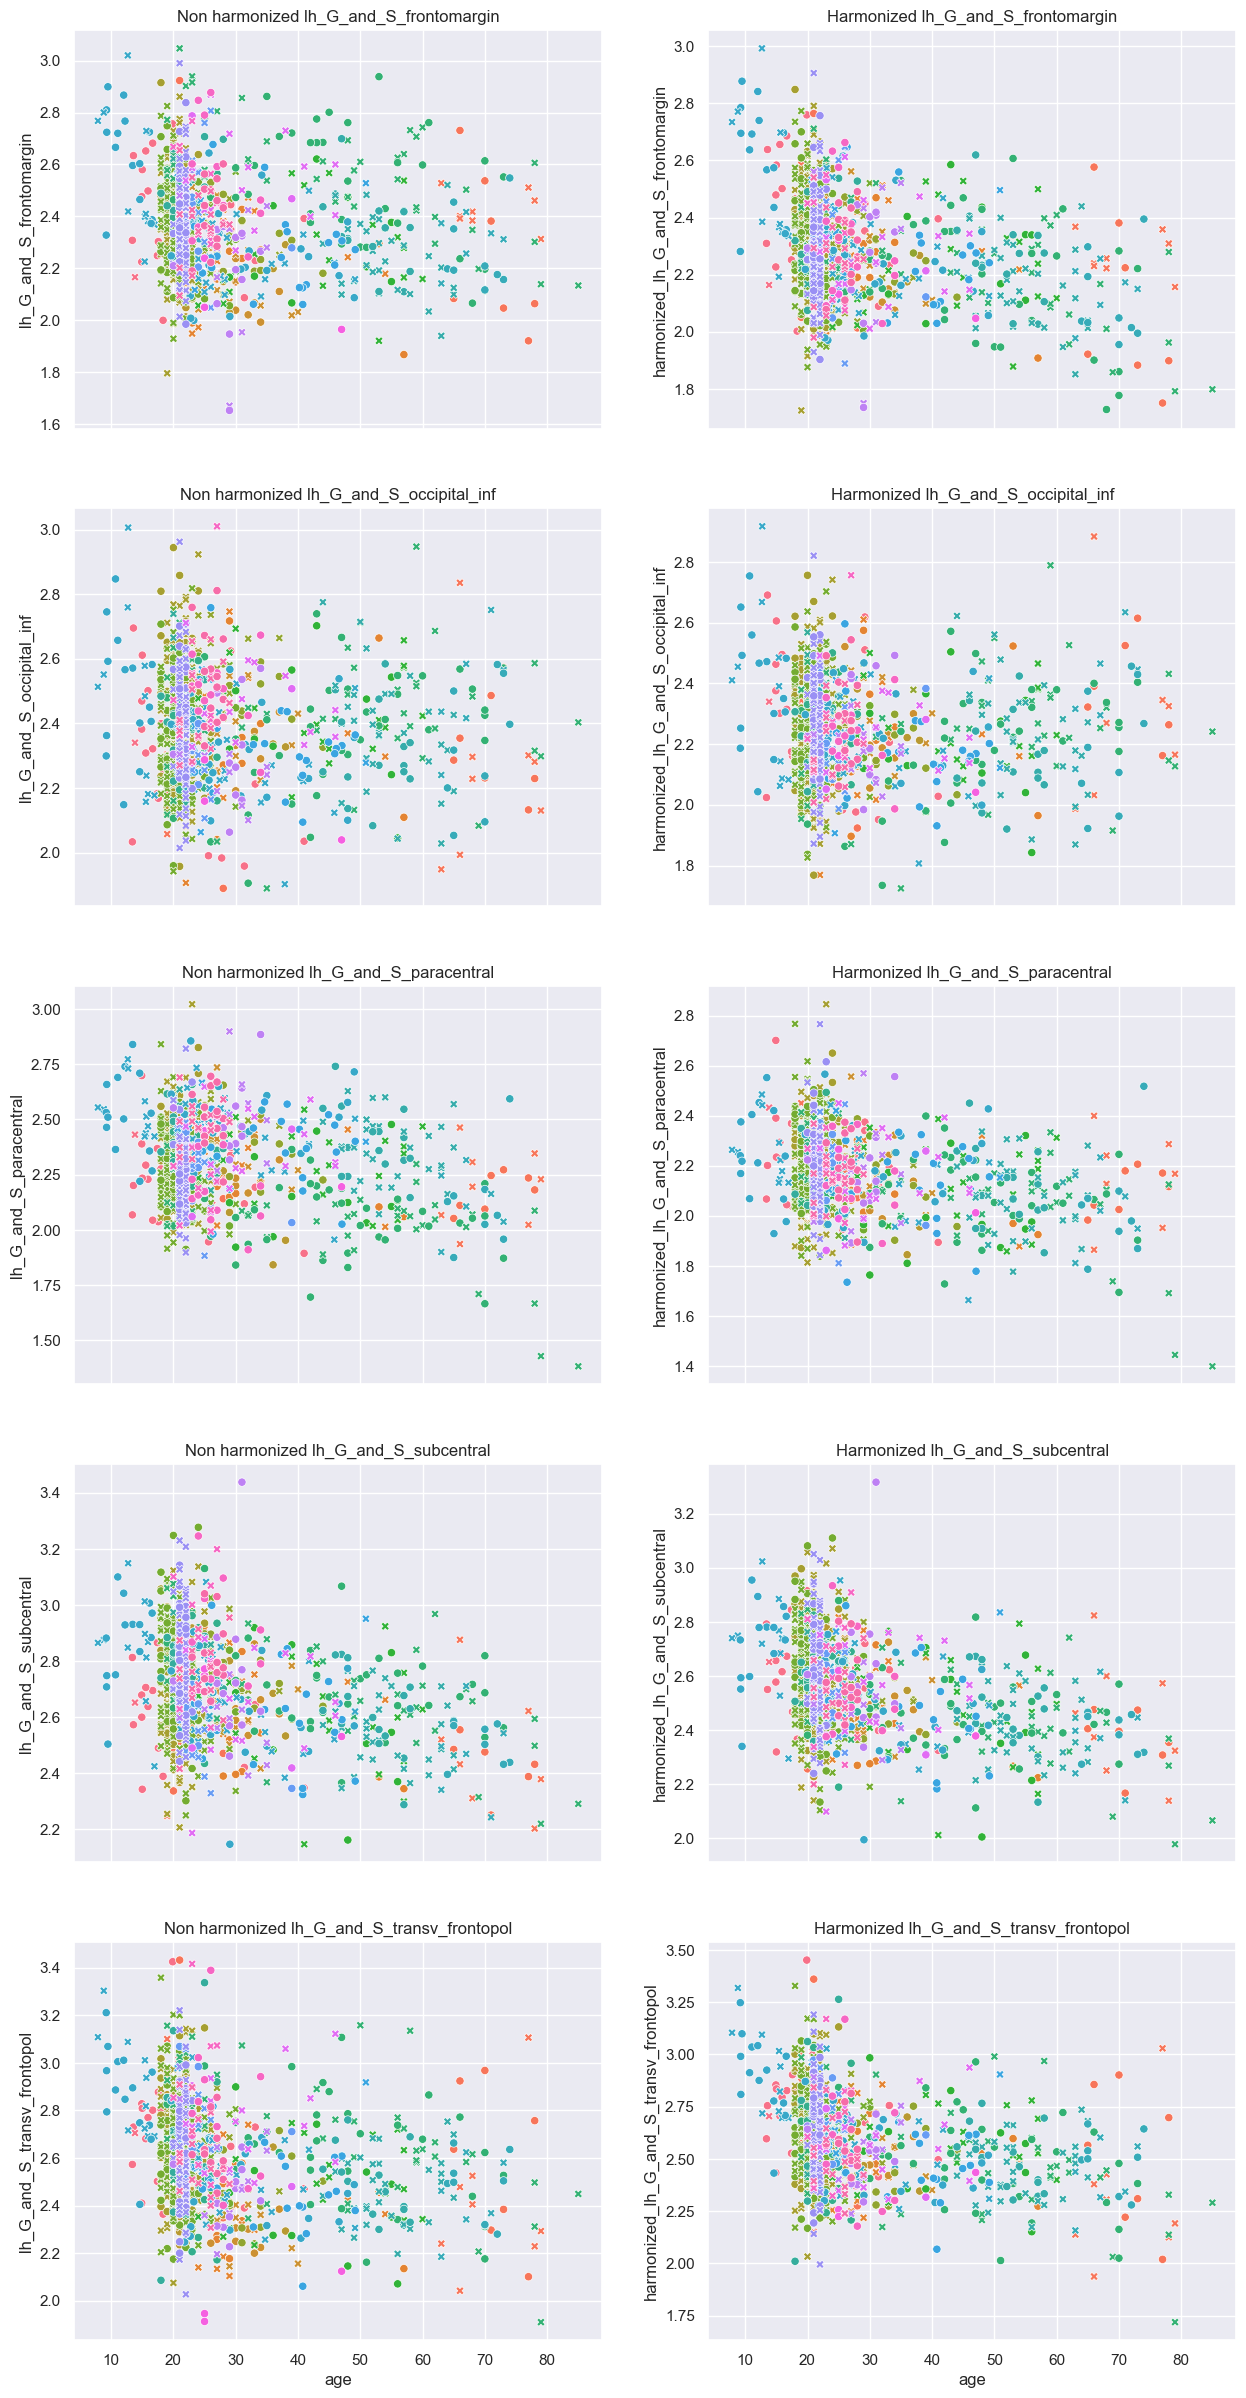

In [126]:
fig, ax = plt.subplots(len(response_variables),2, figsize=(15,30), sharex=True)

# First plot the data as it is 
for i, f in enumerate(response_variables):
    ax[i,0].set_title(f"Non harmonized {f}")
    ax[i,1].set_title(f"Harmonized {f}")
    sns.scatterplot(df, x="age", y=f, hue="site", style="sex", legend=False, ax=ax[i,0])
    sns.scatterplot(df, x="age", y=f"harmonized_{f}", hue="site", style="sex", legend=False, ax=ax[i,1])

plt.show()

It may not be very obvious, but the harmonized data is generally a bit more squished together, as to make the data all lay on the same centile. This is useful if you want to perform further analysis and want to get rid of group effects first!